In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [2]:
def display_img(im_path):
    dpi = 80
    im_data = plt.imread(im_path)
    
    # If the image is grayscale, add a dummy channel to maintain compatibility
    if len(im_data.shape) == 2:  # Grayscale image
        im_data = im_data[:, :, np.newaxis]
    
    print(im_data.shape)
    height, width = im_data.shape[:2]

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axis that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    ax.axis('off')

    # Handle grayscale separately for display
    if im_data.shape[-1] == 1:
        ax.imshow(im_data[:, :, 0], cmap='gray')
    else:
        ax.imshow(im_data)

    plt.show()


(1080, 1920, 3)


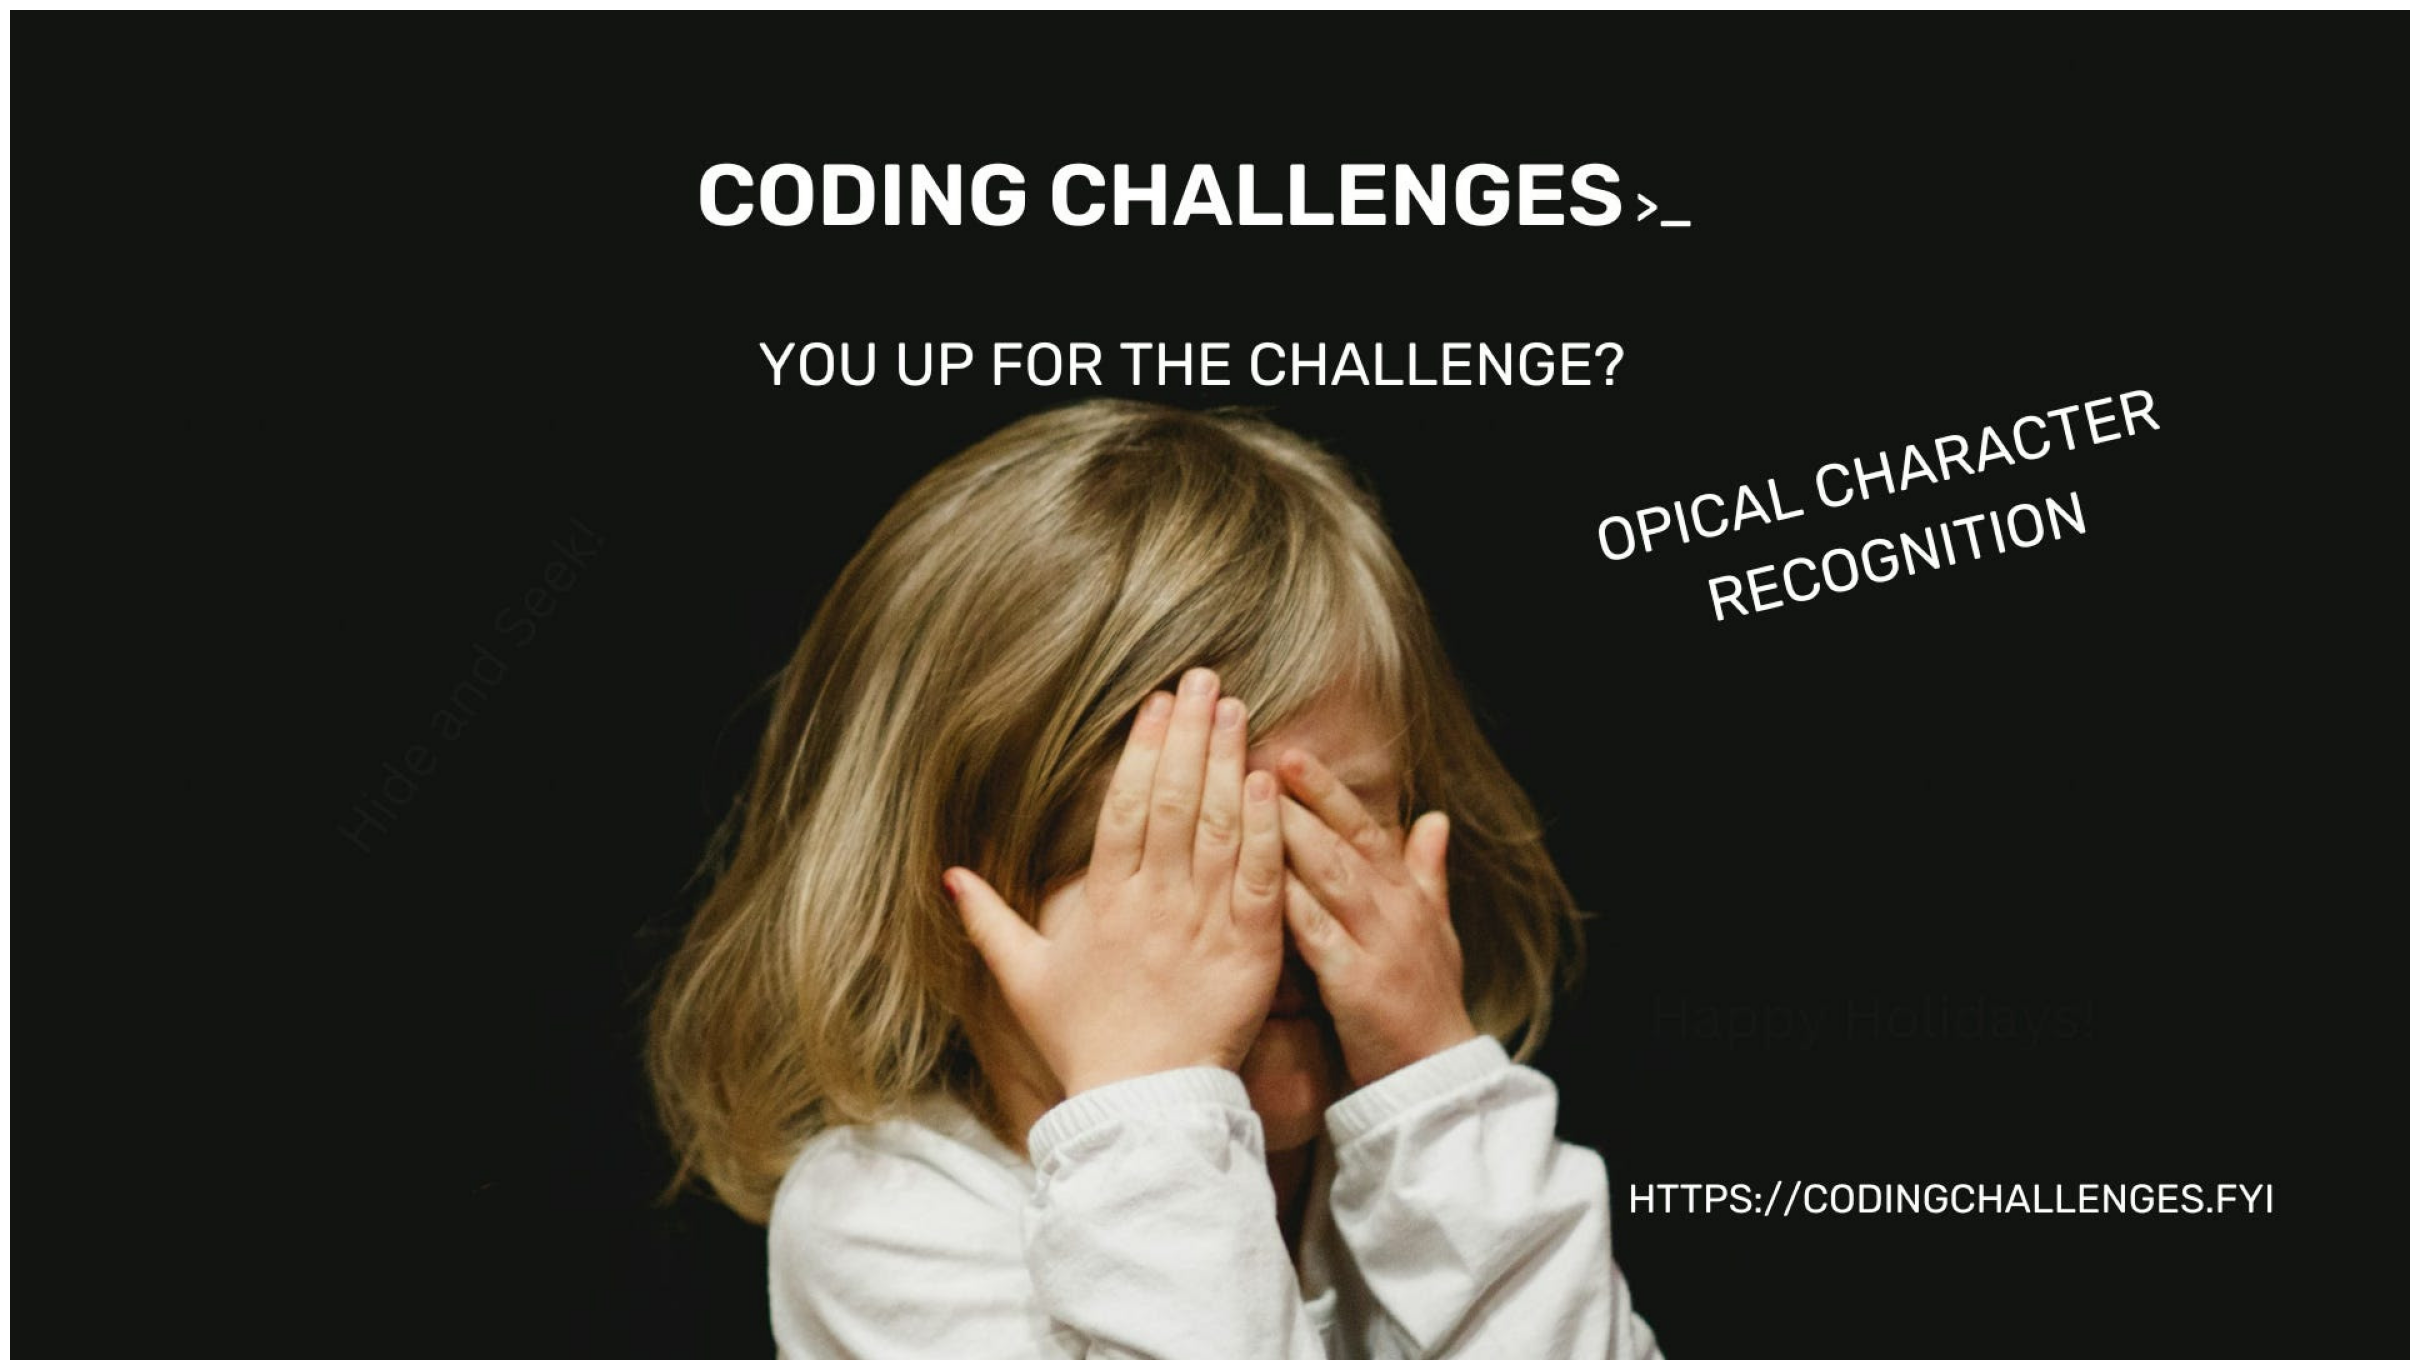

In [4]:
im = cv2.imread('../assets/image_01.jpg')
display_img('../assets/image_01.jpg')

In [5]:
grayscale_im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

# Simple Thresholding
`cv2.threshold(img_src, thresh, maxval, thresholdingTechnique) -> retval, dst`

- `thresh`: Value of Threshold below and above which pixel values will change accordingly.
- `maxval`: The value to be given if pixel value is more than (sometimes less than) the threshold value.
- `thresholdingTechnique`: The type of thresholding to be applied.
- Thresholding Techniques: cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV, cv2.THRESH_TRUNC, cv2.THRESH_TOZERO, cv2.THRESH_TOZERO_INV

(1080, 1920, 1)


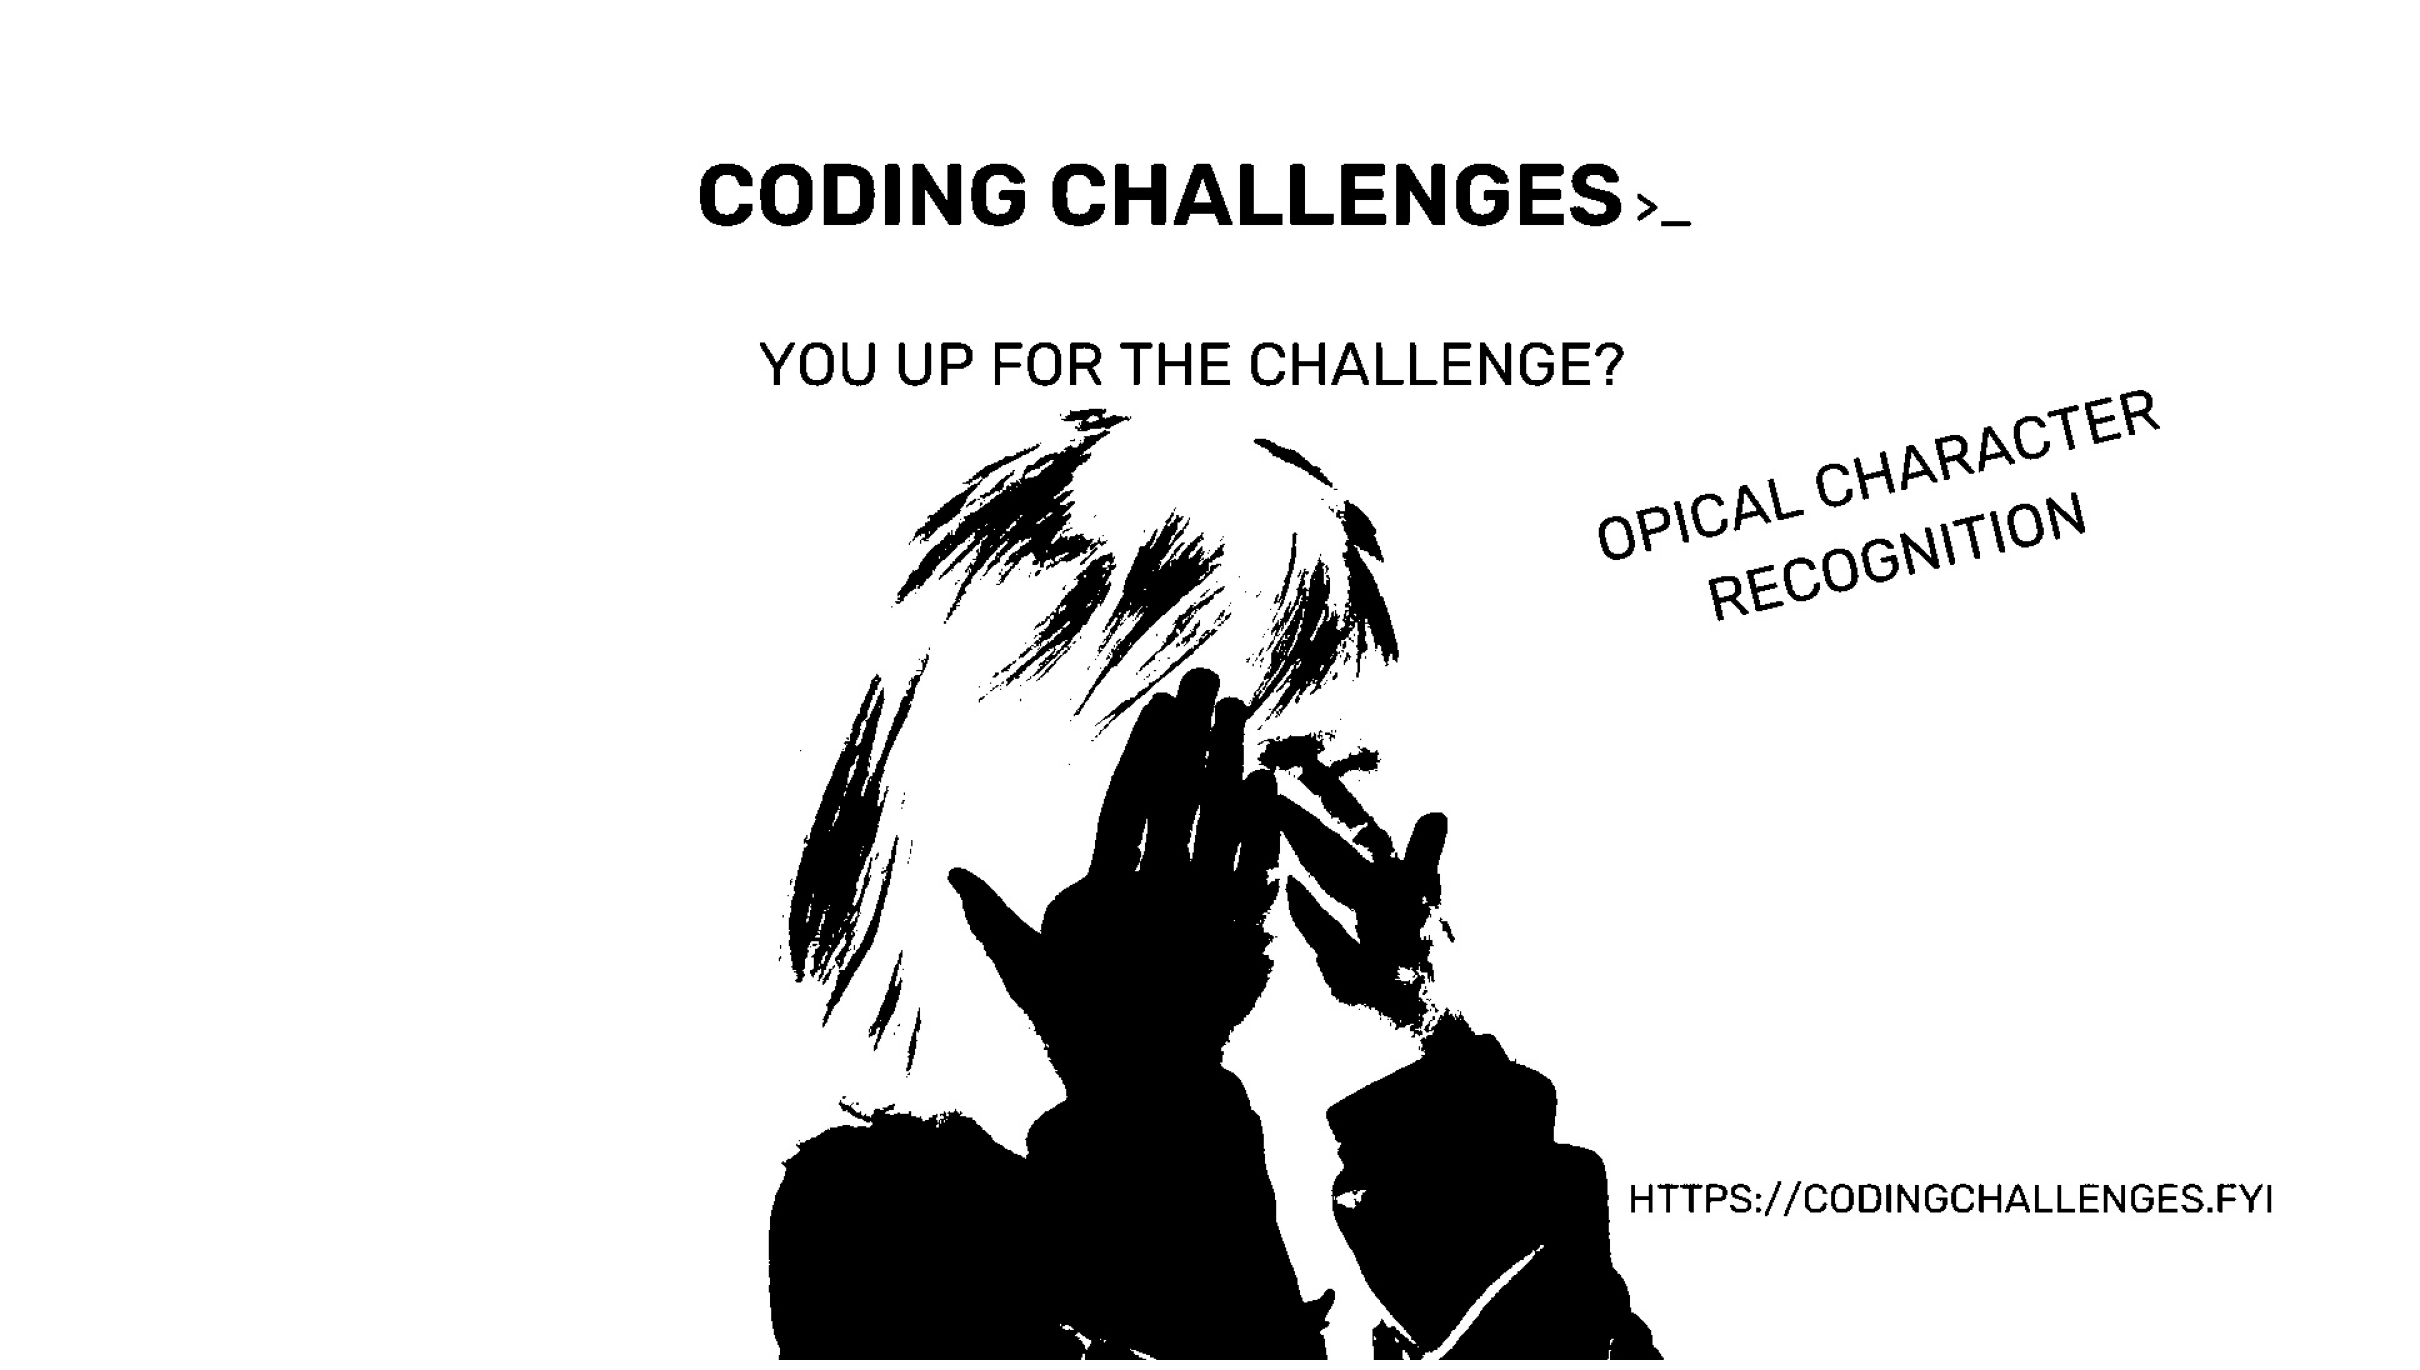

In [20]:
display_img('../assets/cc/image_01_binary.jpg')

# Adaptive Thresholding
`cv2.adaptiveThreshold(img_src, maxval, adaptiveMethod, thresholdType, blockSize, constant) -> dst`

- `maxval`: The value to be given if pixel value is more than the threshold value.
- `adaptiveMethod`: cv2.ADAPTIVE_THRESH_MEAN_C, cv2.ADAPTIVE_THRESH_GAUSSIAN_C
- `thresholdType`: cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV
- `blockSize`: Size of a pixel neighborhood that is used to calculate a threshold value for the pixel: 3, 5, 7, and so on.
- `constant`: Constant subtracted from the mean or weighted mean

In [26]:
adp_thresh = cv2.adaptiveThreshold(grayscale_im, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 5)
cv2.imwrite('../assets/cc/image_01_adaptive.jpg', adp_thresh)

True

(1080, 1920, 1)


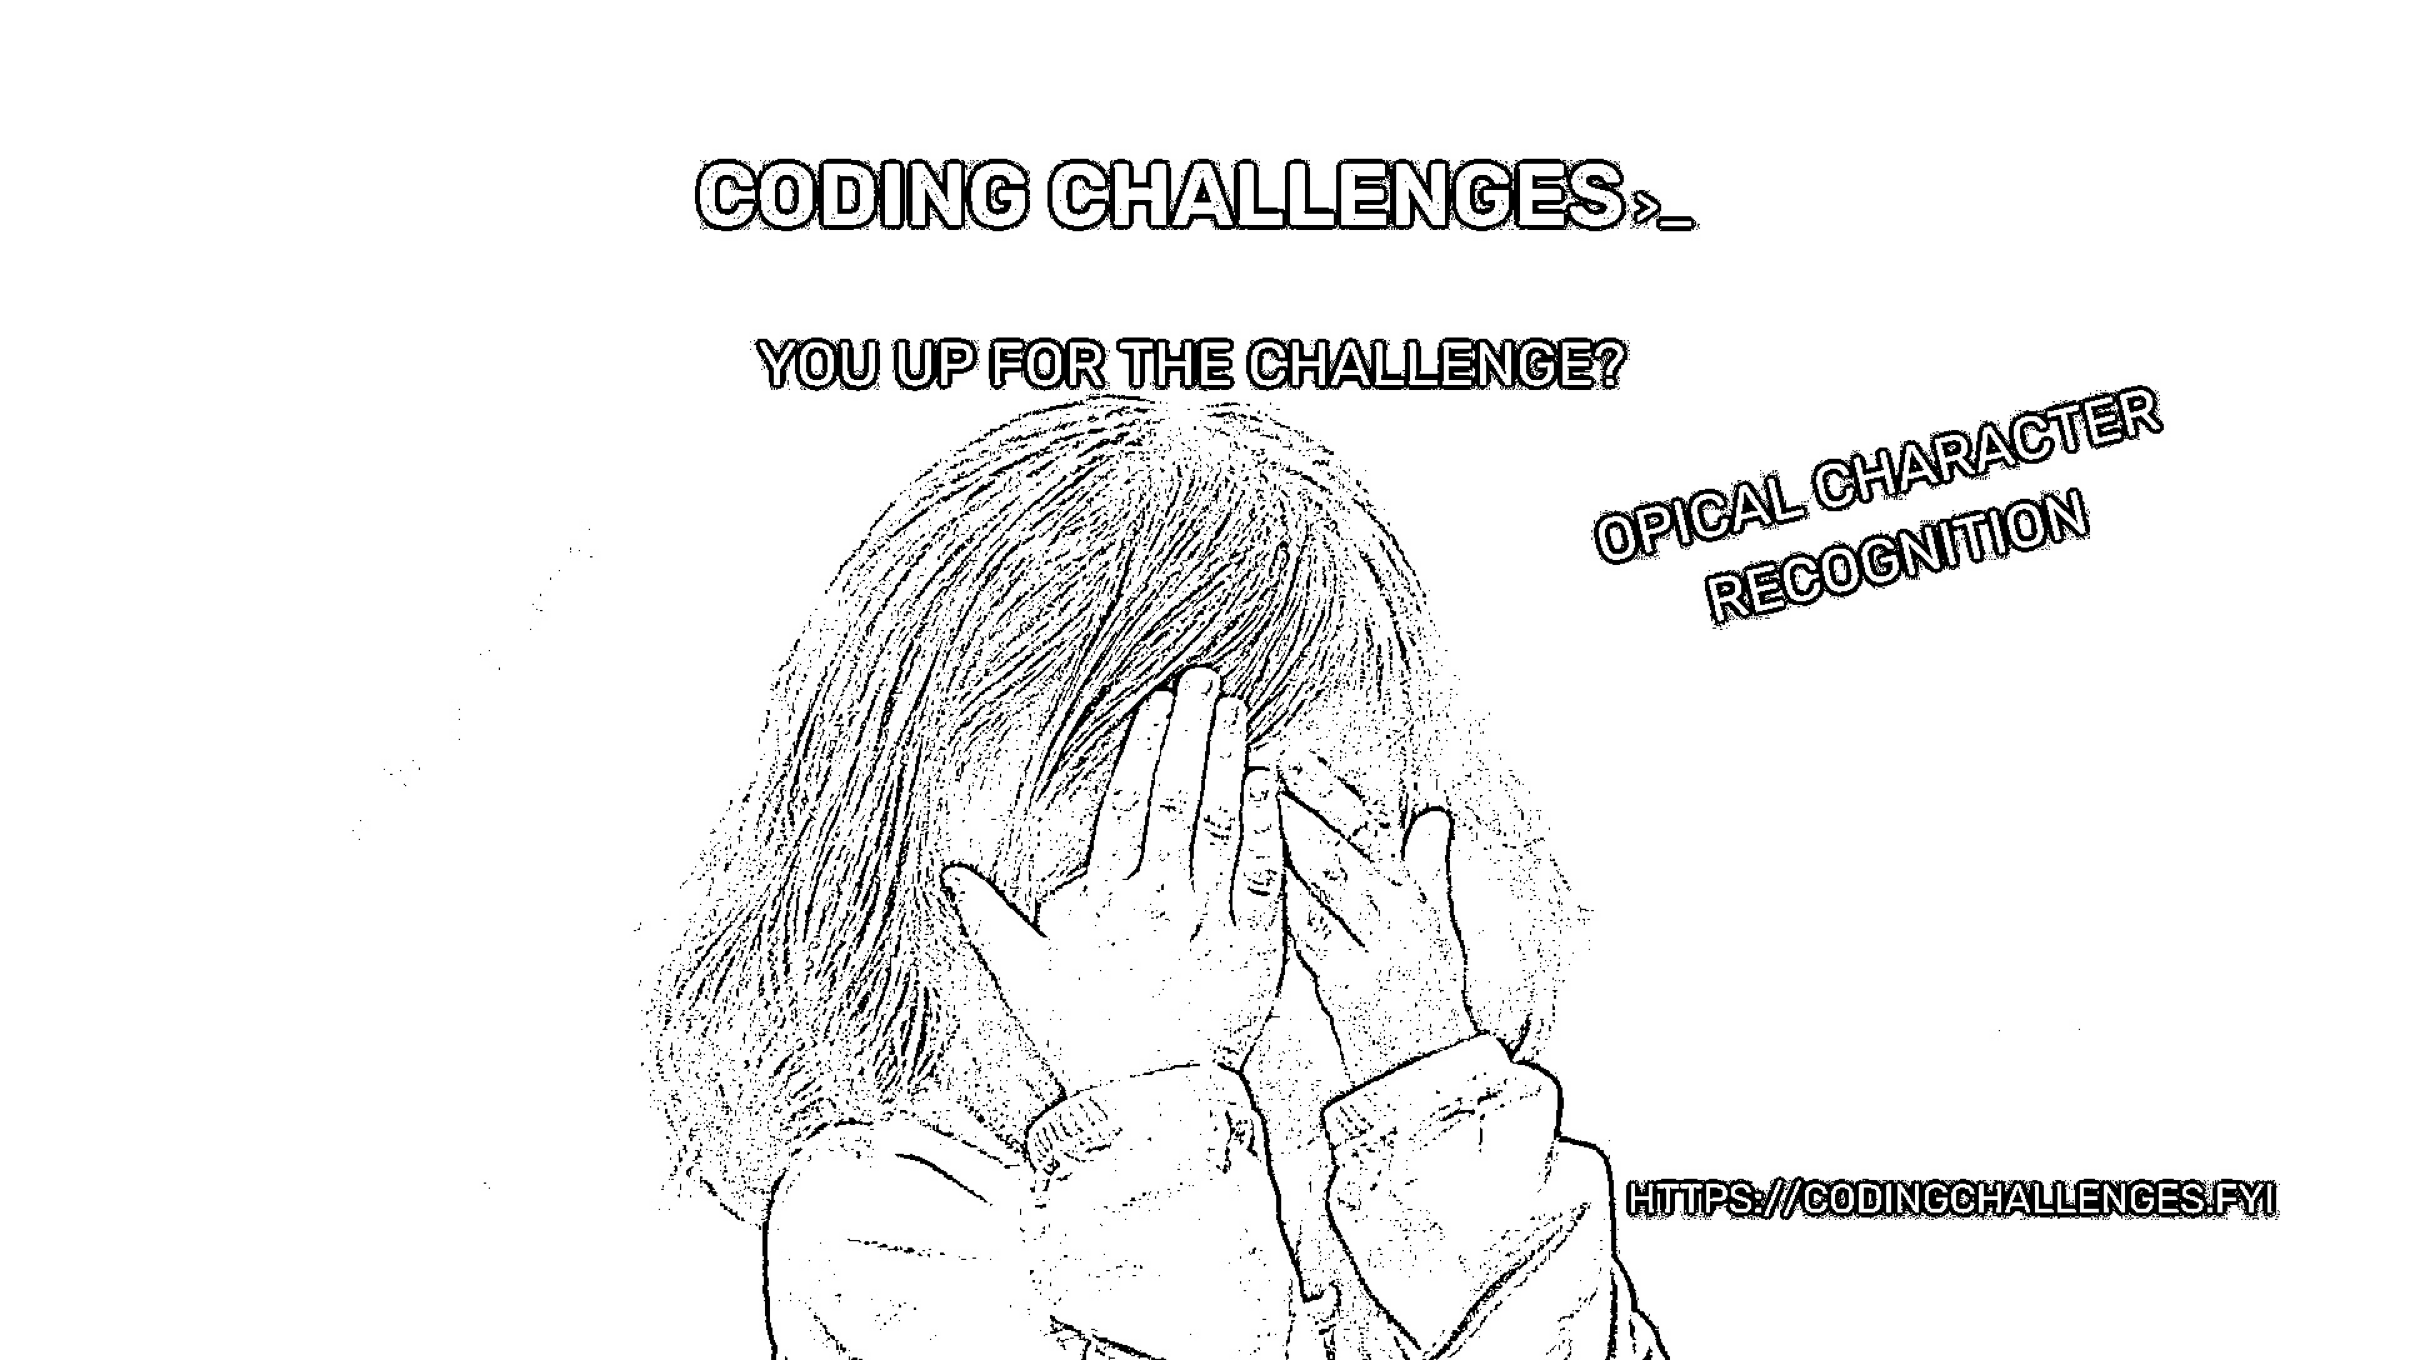

In [29]:
display_img('../assets/cc/image_01_adaptive.jpg')

# Otsu Thresholding
`cv2.threshold(source, thresholdValue, maxVal, thresholdingTechnique)`

- `thresholdValue`: Value of Threshold below and above which pixel values will change accordingly.
- `maxVal`: Maximum value that can be assigned to a pixel.
- `thresholdingTechnique`: The type of thresholding to be applied. Use `cv2.THRESH_OTSU` for thresholding technique

In [32]:
_, otsu_thresh = cv2.threshold(grayscale_im, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
cv2.imwrite('../assets/cc/image_01_otsu.jpg', otsu_thresh)

True

(1080, 1920, 1)


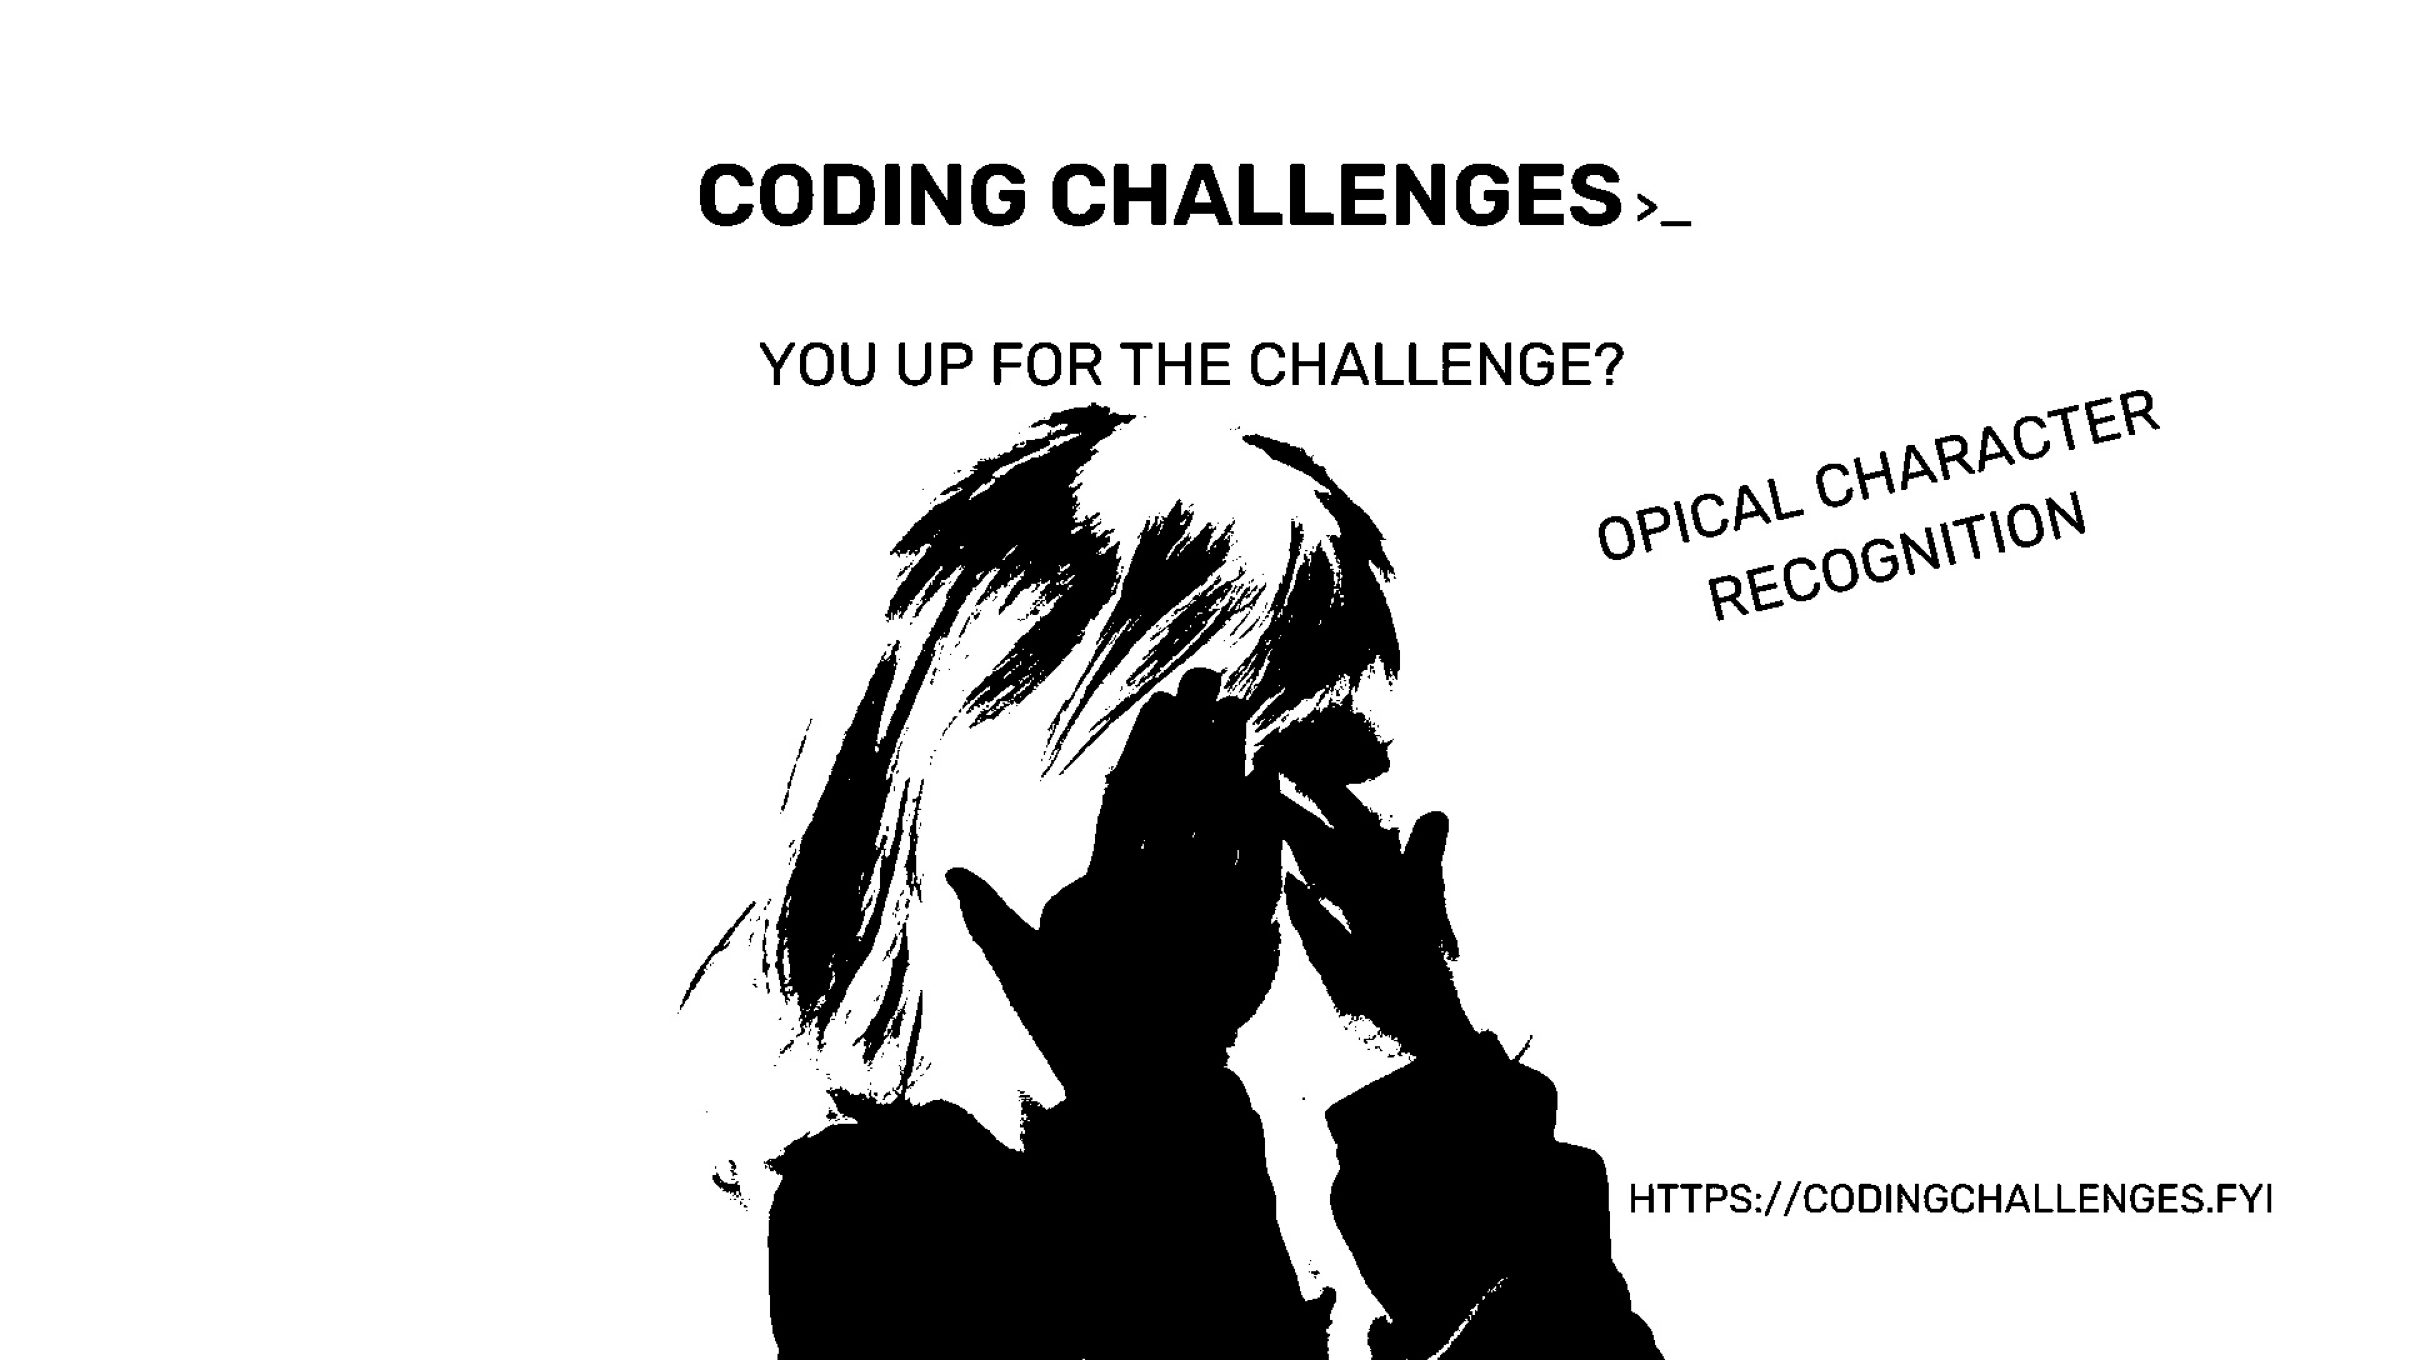

In [33]:
display_img('../assets/cc/image_01_otsu.jpg')

(1080, 1920, 1)


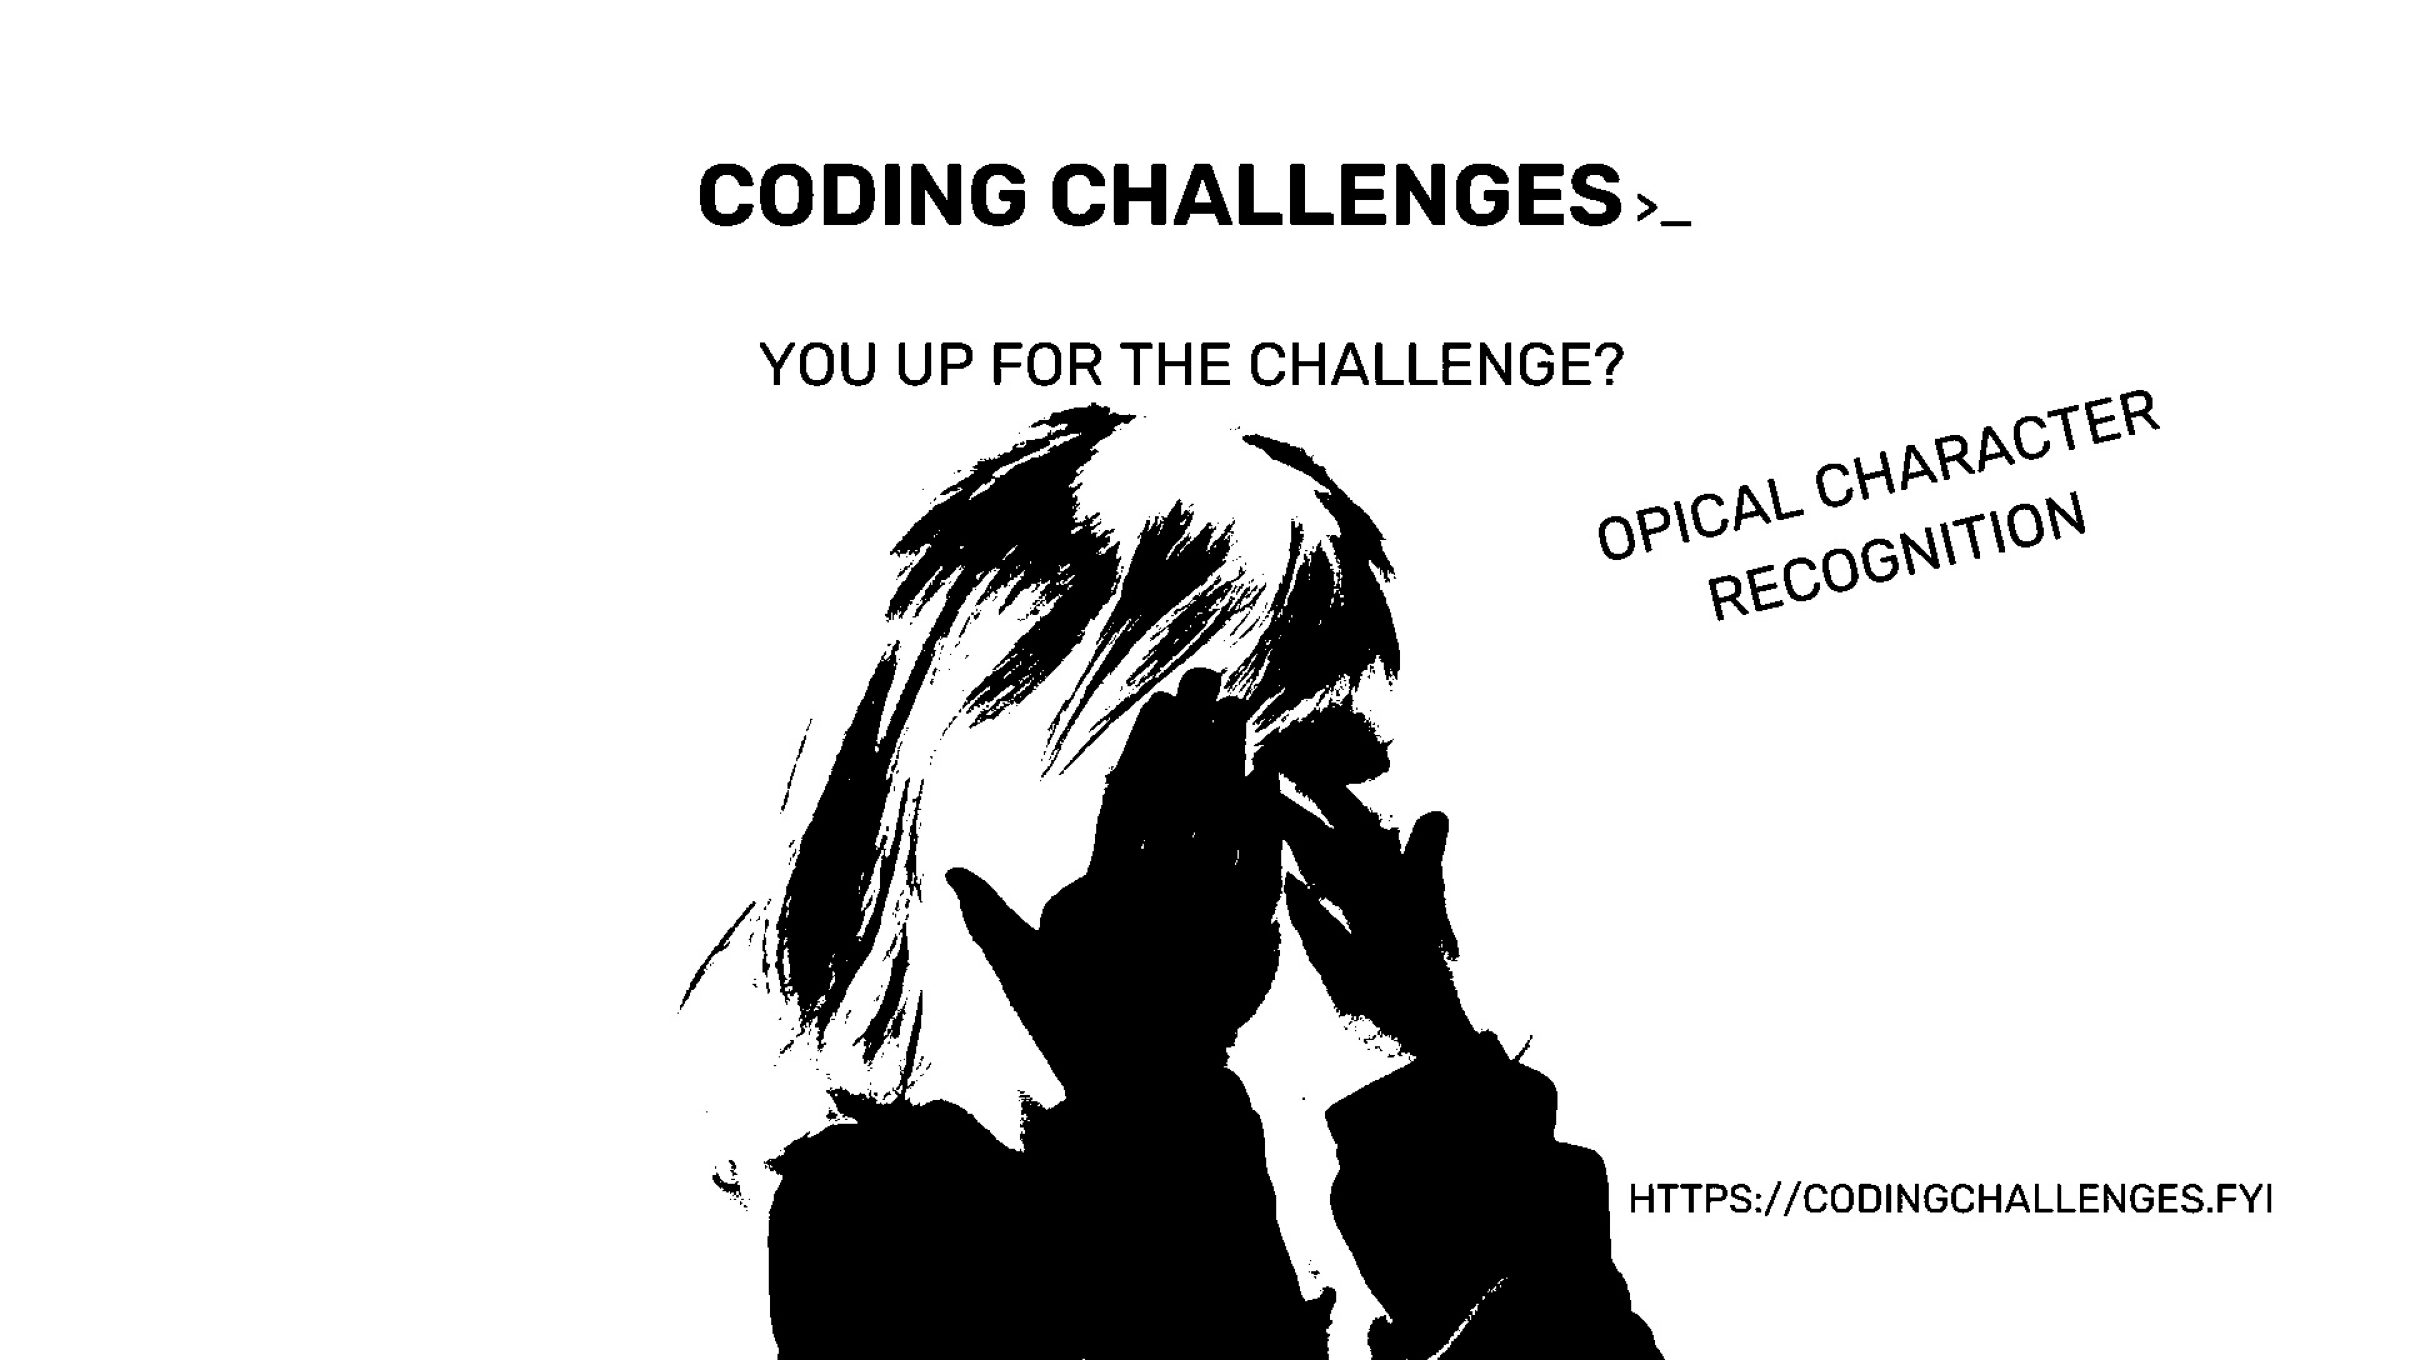

In [53]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 1))
dilated_image = cv2.dilate(otsu_thresh, kernel, iterations=1)
cv2.imwrite('../assets/cc/image_01_otsu_dilated.jpg', dilated_image)
display_img('../assets/cc/image_01_otsu_dilated.jpg')


## Search for Contours

In [61]:
# Find contours in the binary image
contours, hierarchy = cv2.findContours(dilated_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Draw the contours on the original image
contour_image = im.copy()
cv2.drawContours(contour_image, contours, -1, (0, 255, 0), 2)


# Loop through each contour and extract the bounding boxes
for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    
    # Draw a rectangle around each contour
    cv2.rectangle(contour_image, (x, y), (x + w, y + h), (255, 0, 0), 2)
    
    # Crop and process the region of interest (ROI) if needed
    roi = im[y:y+h, x:x+w]
    # You can run OCR on the cropped region here if needed


# Display the resulting image with contours
cv2.imshow('Contours', contour_image)
cv2.waitKey(0)
cv2.destroyAllWindows()

## Rotate Text in image

In [37]:
#https://becominghuman.ai/how-to-automatically-deskew-straighten-a-text-image-using-opencv-a0c30aed83df
def getSkewAngle(cvImage) -> float:
  # Prep image, copy, convert to gray scale, blur, and threshold
  newImage = cvImage.copy()
  gray = cv2.cvtColor(newImage, cv2.COLOR_BGR2GRAY)
  blur = cv2.GaussianBlur(gray, (9, 9), 0)
  thresh = cv2.threshold(blur, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

  # Apply dilate to merge text into meaningful lines/paragraphs.
  # Use larger kernel on X axis to merge characters into single line, cancelling out any spaces.
  # But use smaller kernel on Y axis to separate between different blocks of text
  kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
  dilate = cv2.dilate(thresh, kernel, iterations=2)

  # Find all contours
  contours, hierarchy = cv2.findContours(dilate, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
  contours = sorted(contours, key = cv2.contourArea, reverse = True)
  for c in contours:
      rect = cv2.boundingRect(c)
      x,y,w,h = rect
      cv2.rectangle(newImage,(x,y),(x+w,y+h),(0,255,0),2)

  # Find largest contour and surround in min area box
  largestContour = contours[0]
  print (len(contours))
  minAreaRect = cv2.minAreaRect(largestContour)
  cv2.imwrite("temp/boxes.jpg", newImage)
  # Determine the angle. Convert it to the value that was originally used to obtain skewed image
  angle = minAreaRect[-1]
  if angle < -45:
      angle = 90 + angle
  return -1.0 * angle


# Rotate the image around its center
def rotateImage(cvImage, angle: float):
  newImage = cvImage.copy()
  (h, w) = newImage.shape[:2]
  center = (w // 2, h // 2)
  M = cv2.getRotationMatrix2D(center, angle, 1.0)
  newImage = cv2.warpAffine(newImage, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
  return newImage

In [38]:
# Deskew image
def deskew(cvImage):
  angle = getSkewAngle(cvImage)
  return rotateImage(cvImage, -1.0 * angle)

In [43]:
ostu_im = cv2.imread('../assets/cc/image_01_otsu.jpg')
fixed_im = deskew(ostu_im)
cv2.imwrite('../assets/cc/image_01_otsu_fixed.jpg', fixed_im)

9


True

(1080, 1920, 3)


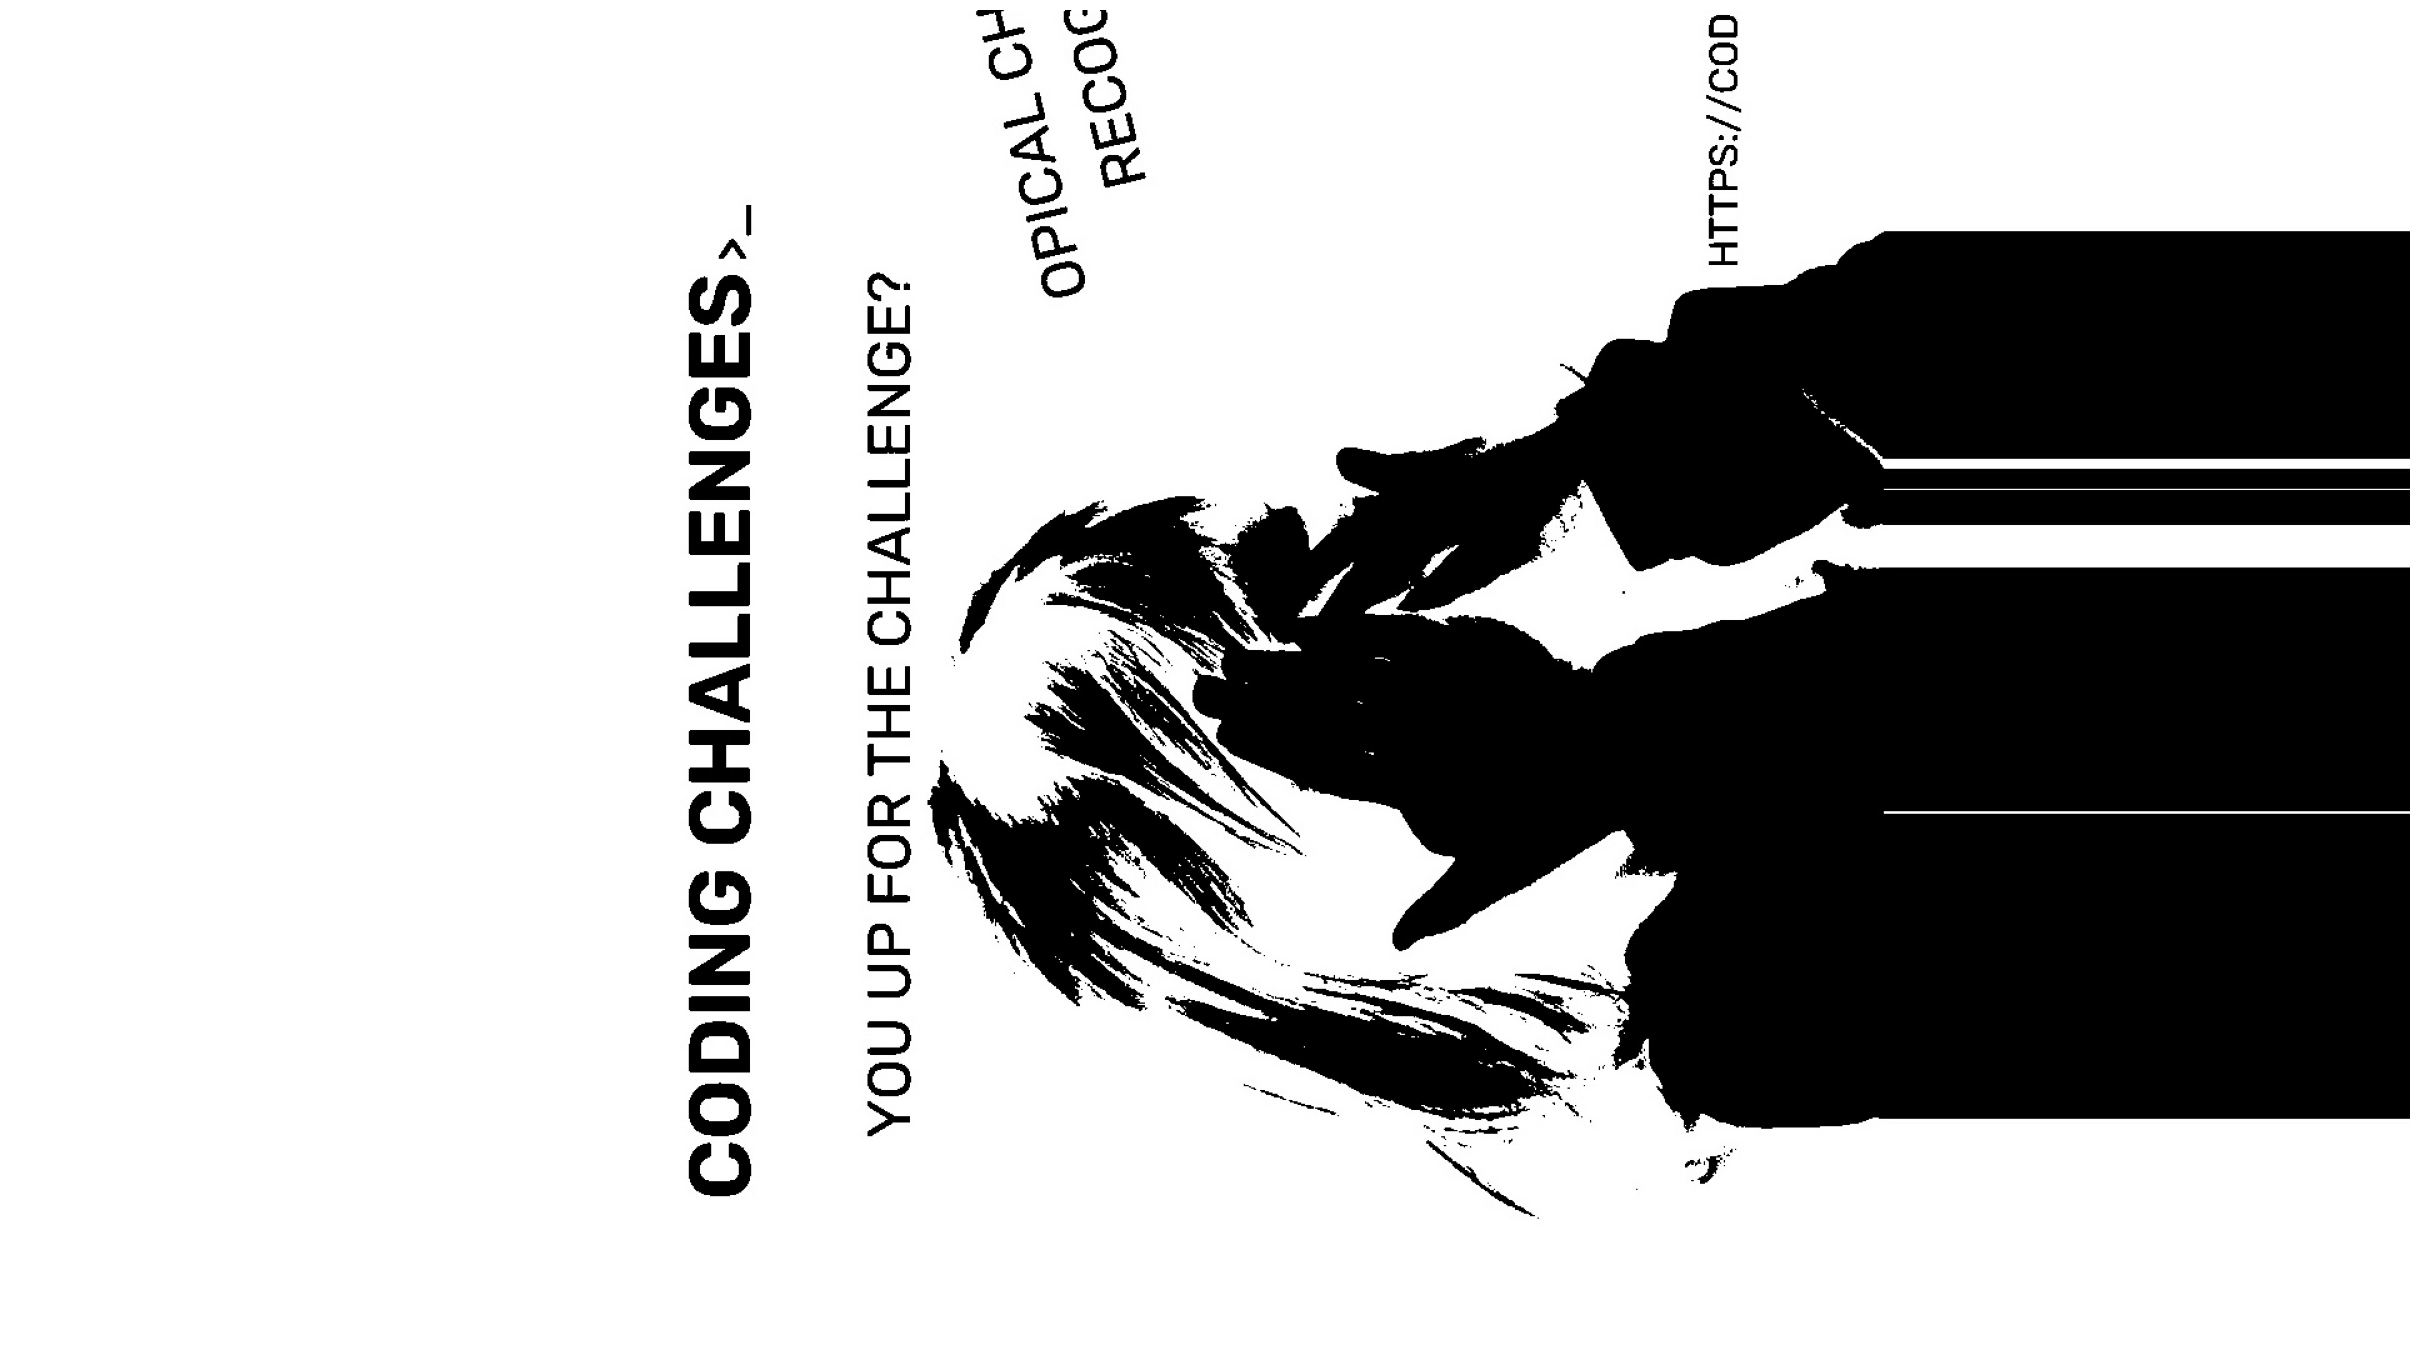

In [44]:
display_img('../assets/cc/image_01_otsu_fixed.jpg')

# Using pytesseract to read from image

In [35]:
import pytesseract
from PIL import Image

In [57]:
otsu_img = "../assets/cc/image_01_otsu_dilated.jpg"

CODING CHALLENGES >_
YOU UP FOR THE CHALLENGE? R
IP opIcAL?wni0N
7 HTTPS://CODINGCHALLENGES.FY!

(1080, 1920, 1)


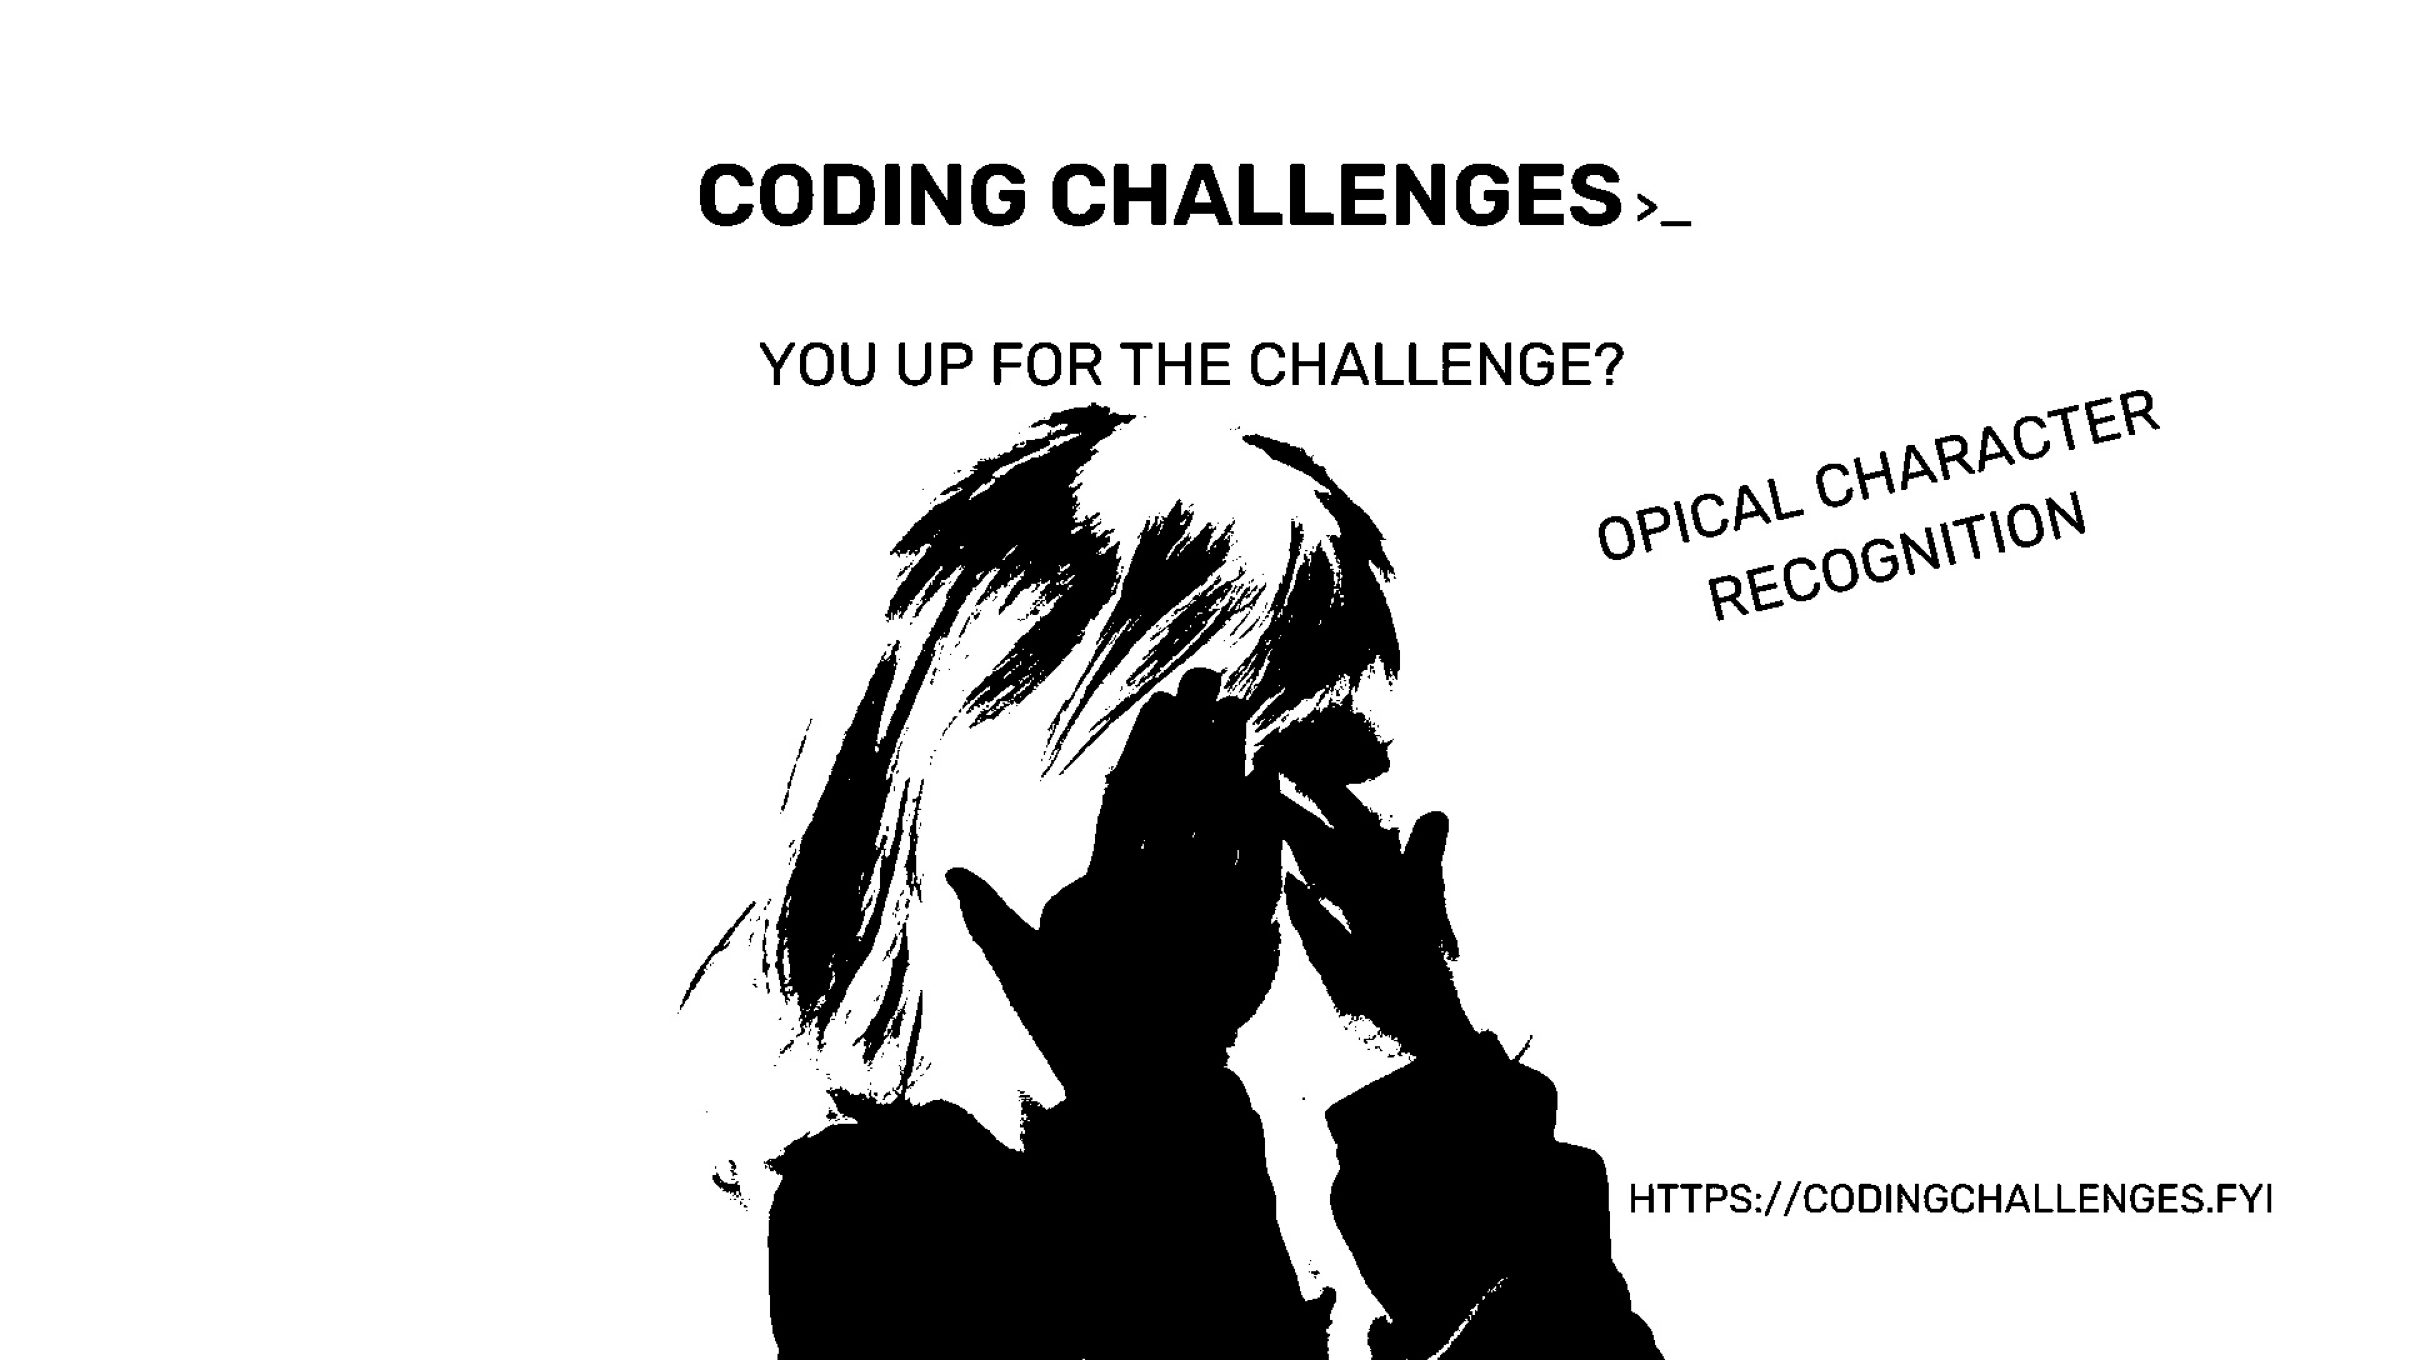

In [59]:
img = Image.open(otsu_img)
custom_config = r'--oem 3 --psm 6'
ocr_result = pytesseract.image_to_string(img, config=custom_config)

print(ocr_result)
display_img('../assets/cc/image_01_otsu_dilated.jpg')